In [140]:
import json
from transformers import AutoTokenizer, AutoModelForCausalLM
from pathlib import Path
import numpy as np

In [141]:


# Read data from JSON Lines file
def read_jsonl_file(file_path):
    data_list = []
    with open(file_path, 'r') as file:
        for line in file:
            # Parse JSON object from each line
            json_obj = json.loads(line)
            data_list.append(json_obj)

    # Print the data read from the file
    return data_list

In [142]:

model_path = {'mistral7b': 'mistralai/Mistral-7B-Instruct-v0.1',
             'falcon7b': 'tiiuae/falcon-7b-instruct',
             'llama7b': '/work/frink/models/Llama-2-7b-chat-hf',
             'flanul2': 'google/flan-ul2'}

def load_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_path[model_name],
                                         cache_dir = '/scratch/ramprasad.sa/huggingface_models')

    
    return tokenizer

In [143]:

import re
import string

def check_only_trailing_punctuations(token_list):
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    for idx in [0, len(token_list) - 1]:
        if idx <= len(token_list) - 1:
            if not regex.sub('', token_list[idx][1]).strip():
                token_list.pop(idx)
    return token_list

def add_word_list(token_list, word_list):
    token_list = check_only_trailing_punctuations(token_list)
    if token_list:
        word_list.append(token_list)
    return word_list
    
def get_word_based_idx(summary_tokens,
                      tokenizer):
    all_words = []
    token_list = []
    for summ_tok_idx, summ_tok in enumerate(summary_tokens):
        prefix_tok_str = ''
        current_tok_str = tokenizer.decode(summ_tok)
        if summ_tok_idx > 0:
            prefix_tok_str = tokenizer.decode([summary_tokens[summ_tok_idx - 1], summ_tok])

        #### new token is start of a new word 
        if len(prefix_tok_str.split(' '))> 1:

            ### append stored tokens of a previous word
            if len(token_list) > 0:
                all_words = add_word_list(token_list, all_words)

            #### now reset token list for new word 
            token_list = [(summ_tok_idx, current_tok_str, summ_tok, )]
            
        else:
            token_list.append((summ_tok_idx, current_tok_str, summ_tok))

    all_words = add_word_list(token_list, all_words)
    return all_words



    # print(current_tok, len(word_list))
    # if len(prefix_str.split(' ')) 
    # if prev_tok is None or 
    # summ_tok_label = summary_label[summ_tok_idx]
    # summ_tok_layers_patches = summary_token_patching_results[summ_tok_idx]
    # for layer_idx, tgt_token, _, pred_token, p_clean, p_corr, p_patched in summ_tok_layers_patches:
    #     ie_score = (p_patched - p_corr) / (p_clean - p_corr)
        

In [163]:
directory_path = '/scratch/ramprasad.sa/probing_summarization_factuality/causal_analysis/noised_instruction/ACIBENCH/mistral7b/'
directory = Path(directory_path)
files = [file.name for file in directory.iterdir() if file.is_file()]
files_data = [read_jsonl_file(f'{directory_path}/{file}') for file in files]


In [164]:

# files_data[0]

In [165]:
tokenizer = load_tokenizer('mistral7b')

/home/ramprasad.sa/.conda/envs/nnsight/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [178]:
import math 


def get_all_summary_words(files_data):
    files_summary_words = []

    for data_list in files_data:
        summary_tokens = [ each[0]['target'] for each in data_list]
        summary_labels = [each[0]['factual_label'] for each in data_list]
        summary_words = get_word_based_idx(summary_tokens, 
                       tokenizer)
        files_summary_words.append(summary_words)
    return files_summary_words


def get_ie_score(layerwise_result):
    predicted = layerwise_result['predicted']
    target = layerwise_result['target']
    factual_label = layerwise_result['factual_label']
    layer_num = layerwise_result['layer']
    prob_clean = layerwise_result['prob_clean']
    prob_corrupted = layerwise_result['prob_corrupted']
    prob_patched = layerwise_result['prob_patched']
                    
    if predicted == target:
        ie_score = (prob_patched - prob_corrupted) / (prob_clean - prob_corrupted)
        # ie_score = prob_patched - prob_corrupted
        return ie_score
    return None


def make_df_patching(files_data):
    df_dict_patching = { f'layer_{layer_num}': [] for layer_num in range(len(files_data[0][0]))}
    df_dict_patching['token_pos'] = []
    df_dict_patching['token_factual_label'] = []

    files_summary_words = get_all_summary_words(files_data)
    #### go through all summaries in the file data
    for file_idx, summary_words in enumerate(files_summary_words):
        data_list = files_data[file_idx]
        ### for each summary word in the list of words
        for summ_word in summary_words:
            #### since each word can have many tokens, go through each token for that word
            for tok_pos, tok_info in enumerate(summ_word):
                tok_idx = tok_info[0]
                tok_layerwise_results = data_list[tok_idx]
                appended = False
                
                for layerwise_res in tok_layerwise_results:
                    
                    layer_num = layerwise_res['layer']
                    ie_score = get_ie_score(layerwise_res)
                    # print(layerwise_res)
                    if ie_score != None:
                        appended = True
                        df_dict_patching[f'layer_{layer_num}'] += [ie_score]
                        
                if appended:
                    tok_pos_str = 'middle'
                    if tok_pos ==0:
                        tok_pos_str = 'first'
                    elif tok_pos == len(summ_word) -1:
                        tok_pos_str = 'last'
                    df_dict_patching['token_pos'] += [tok_pos_str]
                    # sample_layer_res = data_list[summ_word[0][0]][0]
                    df_dict_patching['token_factual_label'] += [data_list[summ_word[0][0]][0]['factual_label']]
                    if tok_pos_str == 'last' and data_list[summ_word[0][0]][0]['factual_label'] == 1:
                        print(summ_word, tok_layerwise_results[24])
    return pd.DataFrame(df_dict_patching)


def get_aie_scores(df_dict_patching):
    df_dict_plot = {f'layer_{layer_num}': [] for layer_num in range(0, len(data_list[0]) + 1, 6)}
    df_dict_plot['Token'] = []
    print(df_dict_plot)
    
    for token_pos in ['first', 'middle', 'last']:
        for factual_label in [0, 1]:
            factual_label_str = 'factual' if factual_label == 0 else 'nonfactual'
            df_dict_plot['Token'] += [f'{factual_label_str}_{token_pos}']
        
    for token_pos in ['first', 'middle', 'last']:
        for factual_label in [0, 1]:
            df_subset = df_dict_patching[(df_dict_patching['token_factual_label'] == factual_label) & \
                        (df_dict_patching['token_pos'] ==token_pos)]
            if len(df_subset) == 0:
                print(token_pos, factual_label)
                
            factual_label_str = 'factual' if factual_label == 0 else 'nonfactual'
            for layer_num in range(len(data_list[0])):
                layer_num = f'layer_{layer_num}'
                if layer_num in df_dict_plot:
                    df_dict_plot[layer_num] += [np.mean(df_subset[layer_num].values) if len(df_subset) > 0 else 0]

    df_dict_plot = pd.DataFrame(df_dict_plot)
    return df_dict_plot

In [179]:
directory_path = '/scratch/ramprasad.sa/probing_summarization_factuality/causal_analysis/noised_instruction/ACIBENCH/mistral7b/'
directory = Path(directory_path)
files = [file.name for file in directory.iterdir() if file.is_file()]
files_data = [read_jsonl_file(f'{directory_path}/{file}') for file in files]
df_dict_patching_acibench = make_df_patching(files_data)
df_dict_patching_acibench = get_aie_scores(df_dict_patching_acibench)
df_dict_patching_acibench 

[(106, 'adv', 2057), (107, 'il', 309)] {'layer': 24, 'target': 309, 'predicted': 309, 'factual_label': 1, 'prob_clean': 0.9817580580711365, 'prob_corrupted': 2.730239145876112e-07, 'prob_patched': 0.9280261993408203}
[(115, 'relie', 14267), (116, 'vers', 740)] {'layer': 24, 'target': 740, 'predicted': 740, 'factual_label': 1, 'prob_clean': 0.9891676902770996, 'prob_corrupted': 7.16909482889605e-08, 'prob_patched': 0.988733172416687}
[(64, 'COVID', 11747), (65, '-', 28733), (66, '1', 28740), (67, '9', 28774)] {'layer': 24, 'target': 28774, 'predicted': 28774, 'factual_label': 1, 'prob_clean': 0.999909520149231, 'prob_corrupted': 1.3274630873638671e-05, 'prob_patched': 0.9994235038757324}
[(32, 'exp', 2365), (33, 'ir', 361), (34, 'atory', 5377)] {'layer': 24, 'target': 5377, 'predicted': 5377, 'factual_label': 1, 'prob_clean': 0.9400215744972229, 'prob_corrupted': 1.2623590009752661e-05, 'prob_patched': 0.9299415946006775}
[(35, 'whe', 2277), (36, 'ez', 5620), (37, 'ing', 288)] {'layer':

,layer_0,layer_6,layer_12,layer_18,layer_24,layer_30,Token
0,0.689857,0.910089,0.955070,0.975435,0.999517,1.011009,factual_first
1,0.555601,0.717719,0.951386,0.994951,1.016654,1.016370,nonfactual_first
2,0.789069,0.943408,0.956741,0.976751,0.990001,1.000573,factual_middle
3,0.809716,0.818859,0.846006,0.838384,0.843029,1.005998,nonfactual_middle
4,0.447186,0.734532,0.679619,0.674899,0.646762,0.994074,factual_last
5,0.909774,0.973315,0.943948,0.964494,0.995451,0.998414,nonfactual_last


In [180]:
directory_path = '/scratch/ramprasad.sa/probing_summarization_factuality/causal_analysis/noised_instruction/XSUM/mistral7b/'
directory = Path(directory_path)
files = [file.name for file in directory.iterdir() if file.is_file()]
files_data = [read_jsonl_file(f'{directory_path}/{file}') for file in files]
df_dict_patching_xsum = make_df_patching(files_data)
df_dict_patching_xsum = get_aie_scores(df_dict_patching_xsum)
df_dict_patching_xsum 

[(22, '£', 7642), (23, '1', 28740), (24, '.', 28723), (25, '1', 28740)] {'layer': 24, 'target': 28740, 'predicted': 28740, 'factual_label': 1, 'prob_clean': 0.6830312609672546, 'prob_corrupted': 0.0004332686075940728, 'prob_patched': 0.4225302040576935}
[(1, 'GC', 22278), (2, 'SE', 1151)] {'layer': 24, 'target': 1151, 'predicted': 1151, 'factual_label': 0, 'prob_clean': 0.9999990463256836, 'prob_corrupted': 2.931801930117217e-07, 'prob_patched': 0.9999929666519165}
[(15, 'resign', 22883), (16, 'ation', 352)] {'layer': 24, 'target': 352, 'predicted': 352, 'factual_label': 1, 'prob_clean': 0.9999802112579346, 'prob_corrupted': 6.726170909132634e-07, 'prob_patched': 0.9997797608375549}
[(37, 'repl', 4802), (38, 'ac', 323), (39, 'ements', 4485)] {'layer': 24, 'target': 4485, 'predicted': 4485, 'factual_label': 1, 'prob_clean': 0.9985465407371521, 'prob_corrupted': 1.6273226322027767e-07, 'prob_patched': 0.0003225379332434386}
{'layer_0': [], 'layer_6': [], 'layer_12': [], 'layer_18': [], '

,layer_0,layer_6,layer_12,layer_18,layer_24,layer_30,Token
0,1.294509,0.641212,0.910707,0.947732,0.935663,0.964816,factual_first
1,0.694644,0.783276,0.980929,0.971074,1.022769,0.974604,nonfactual_first
2,0.396447,0.715236,0.811099,0.886658,0.919717,0.998928,factual_middle
3,0.985408,0.981831,0.990281,0.988861,1.002007,1.000559,nonfactual_middle
4,0.860786,0.975834,1.123350,1.243249,1.282962,0.997176,factual_last
5,0.763542,0.652198,0.643184,0.662817,0.654621,0.971098,nonfactual_last


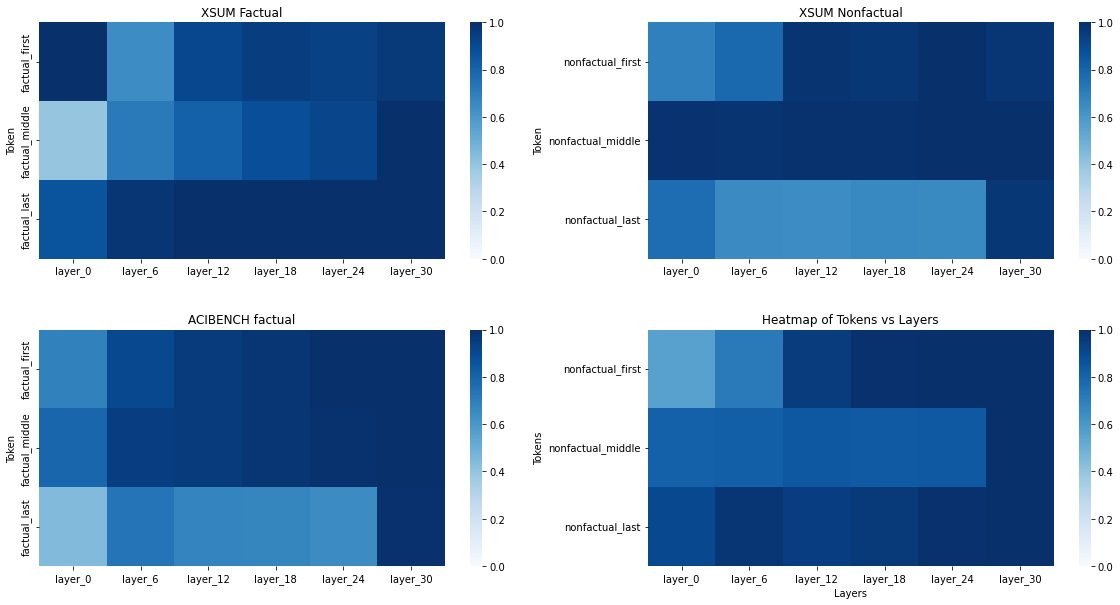

In [192]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 2, figsize=(20, 10), gridspec_kw={'hspace': 0.3})

axes[0][0].set_title("XSUM Factual")
df_dict_plot_factual = df_dict_patching_xsum[df_dict_patching_xsum['Token'].isin(['factual_first',
                                                      'factual_middle',
                                                      'factual_last'])]
df_dict_plot_factual.set_index('Token', inplace=True)
sns.heatmap(df_dict_plot_factual, annot=False, fmt=".2f", cmap=sns.color_palette("Blues", as_cmap=True), vmin=0.0, vmax=1, ax = axes[0][0])



axes[0][1].set_title("XSUM Nonfactual")
df_dict_plot_nonfactual = df_dict_patching_xsum[df_dict_patching_xsum['Token'].isin(['nonfactual_first',
                                                      'nonfactual_middle',
                                                      'nonfactual_last'])]
df_dict_plot_nonfactual.set_index('Token', inplace=True)
sns.heatmap(df_dict_plot_nonfactual, annot=False, fmt=".2f", cmap=sns.color_palette("Blues", as_cmap=True), vmin=0.0, vmax=1, ax = axes[0][1])


axes[1][0].set_title("ACIBENCH factual")
df_dict_plot_factual = df_dict_patching_acibench[df_dict_patching_acibench['Token'].isin(['factual_first',
                                                      'factual_middle',
                                                      'factual_last'])]
df_dict_plot_factual.set_index('Token', inplace=True)
sns.heatmap(df_dict_plot_factual, annot=False, fmt=".2f", cmap=sns.color_palette("Blues", as_cmap=True), vmin=0.0, vmax=1, ax = axes[1][0])


axes[1][1].set_title("ACIBENCH Nonfactual")
df_dict_plot_nonfactual = df_dict_patching_acibench[df_dict_patching_acibench['Token'].isin(['nonfactual_first',
                                                      'nonfactual_middle',
                                                      'nonfactual_last'])]
df_dict_plot_nonfactual.set_index('Token', inplace=True)
sns.heatmap(df_dict_plot_nonfactual, annot=False, fmt=".2f", cmap=sns.color_palette("Blues", as_cmap=True), vmin=0.0, vmax=1, ax = axes[1][1])


# Add labels and title
plt.xlabel("Layers")
plt.ylabel("Tokens")
plt.title("Heatmap of Tokens vs Layers")

# Show plot
plt.show()

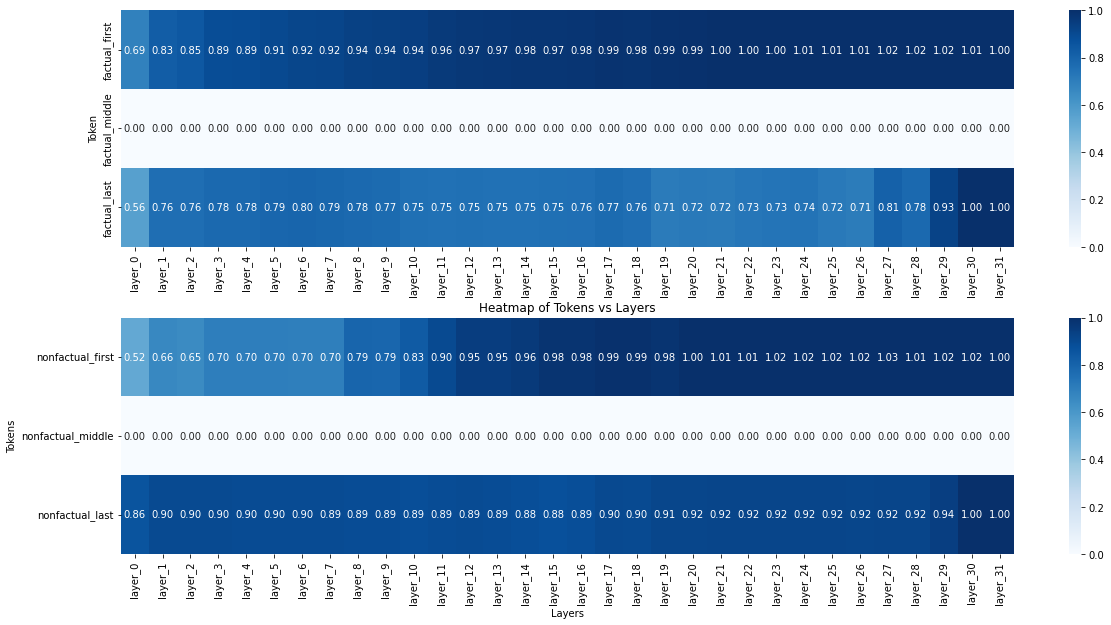

In [159]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 1, figsize=(20, 10), gridspec_kw={'hspace': 0.3})

df_dict_plot_factual = df_dict_patching[df_dict_patching['Token'].isin(['factual_first',
                                                      'factual_middle',
                                                      'factual_last'])]
df_dict_plot_factual.set_index('Token', inplace=True)
sns.heatmap(df_dict_plot_factual, annot=True, fmt=".2f", cmap=sns.color_palette("Blues", as_cmap=True), vmin=0.0, vmax=1, ax = axes[0])


df_dict_plot_nonfactual = df_dict_patching[df_dict_patching['Token'].isin(['nonfactual_first',
                                                      'nonfactual_middle',
                                                      'nonfactual_last'])]
df_dict_plot_nonfactual.set_index('Token', inplace=True)
sns.heatmap(df_dict_plot_nonfactual, annot=True, fmt=".2f", cmap=sns.color_palette("Blues", as_cmap=True), vmin=0.0, vmax=1, ax = axes[1])

# Add labels and title
plt.xlabel("Layers")
plt.ylabel("Tokens")
plt.title("Heatmap of Tokens vs Layers")

# Show plot
plt.show()

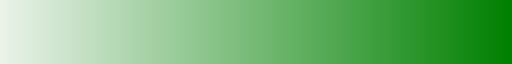

In [125]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.light_palette("green", as_cmap=True)

In [291]:
df_dict_plot_factual